In [1]:
# %%capture
# !pip install pandas numpy matplotlib scikit-image tqdm gdown opencv-python plotly pillow scikit-learn
# !pip install nbformat --upgrade
# !pip install --upgrade jupyter ipywidgets
# !pip install pyimagej scyjava


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import skimage.io as skio
from skimage.color import rgb2gray, rgba2rgb, hsv2rgb
from tqdm.notebook import tqdm as tqdm
from skimage.transform import resize
from copy import deepcopy

import shutil
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

import os
import gdown
import cv2

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image

import json
from matplotlib.patches import Rectangle

In [3]:
def glob_filepath(folder, ext, subfolder=False):
    """
    Get all the filepaths of a folder with a given extension without case sensitivity
    Args: folder -> the folder to search
          ext -> the extension of the files to search for
          subfolder -> whether to include subfolders in the search
    Return: list of filepaths
    """
    filepath = []

    if folder[-1] != '/' and folder != '':
        folder += '/'

    if not isinstance(ext, list):
        ext = [ext]

    if subfolder:
        folder = os.path.join(folder, '**')

    for item in ext:
        # Using glob with case-insensitive patterns
        filepath += glob(os.path.join(folder, '*.' + item), recursive=subfolder)
        filepath += glob(os.path.join(folder, '*.' + item.upper()), recursive=subfolder)
        filepath += glob(os.path.join(folder, '*.' + item.lower()), recursive=subfolder)
    
    return sorted(list(set(filepath)))


In [4]:
%%capture
# !pip install labelme
# !labelme

In [5]:

filepaths = glob_filepath(folder='../data/data_v1/unprocessed', ext=['jpg', 'png', 'jpeg'], subfolder=False)
print(filepaths)

['../data/data_v1/unprocessed/pistachio24_BACK(1) (1) copy.png', '../data/data_v1/unprocessed/pistachio24_BACK(1) (1).JPG', '../data/data_v1/unprocessed/pistachio24_BACK(1) (1).png', '../data/data_v1/unprocessed/pistachio24_BACK(1).JPG', '../data/data_v1/unprocessed/pistachio24_BACK(2).JPG', '../data/data_v1/unprocessed/pistachio24_FRONT(1).JPG', '../data/data_v1/unprocessed/pistachio24_FRONT(2).JPG', '../data/data_v1/unprocessed/pistachio24_FRONT(3).JPG', '../data/data_v1/unprocessed/pistachio24_FRONT(3).png']


In [6]:
def read_image(filepath, show_image=True, return_arr=True):
  try:
    img = skio.imread(filepath)
    if show_image:
      skio.imshow(img)
  except:
    img = Image.open(filepaths[0])
    img_arr = np.array(img)
    if show_image:
      display(img)
    img = img_arr
  if return_arr:
    return(img)



../data/data_v1/unprocessed/pistachio24_FRONT(3).png


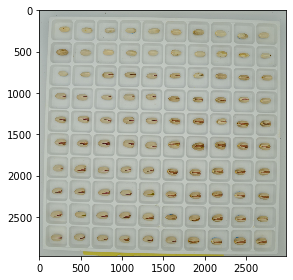

In [7]:
img = read_image(filepath=filepaths[-1], show_image=True, return_arr=True)
fig = px.imshow(img)
print(filepaths[-1])

In [8]:
def sort_contours(contours, y_overlap_threshold=2, sort_by_topmost=False):
    # Group contours into rows based on y-coordinate overlap
    def group_into_rows(contours):
        rows = []
        current_row = [contours[0]]
        for contour in contours[1:]:
            _, current_y, _, current_h = cv2.boundingRect(current_row[-1])
            _, next_y, _, next_h = cv2.boundingRect(contour)
            
            # Check if the contour belongs to the current row
            if min(current_y + current_h, next_y + next_h) - max(current_y, next_y) > y_overlap_threshold:
                current_row.append(contour)
            else:
                rows.append(current_row)
                current_row = [contour]
        
        rows.append(current_row)
        return rows

    # Sort contours in each row based on x-coordinate
    def sort_row(row):
        return sorted(row, key=lambda contour: cv2.boundingRect(contour)[0])

    if sort_by_topmost:
        # Sort contours based on the top y-coordinate
        sorted_contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[1])
    else:
        # First group contours into rows, then sort each row
        contours.sort(key=lambda contour: cv2.boundingRect(contour)[1]) # Sort by top y-coordinate
        rows = group_into_rows(contours)
        sorted_contours = [contour for row in rows for contour in sort_row(row)]

    return sorted_contours


In [9]:
def get_valid_contours(contours):
    """
    Separate valid and invalid contours based on their sizes.

    Parameters:
    contours (list): A list of contours to be separated.

    Returns:
    tuple: A tuple containing two lists: valid_contours and invalid_contours.
    """

    areas = []
    valid_contours = []
    invalid_contours = []

    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        areas.append([w, h]) 

    areas_np = np.array(areas)

    db = DBSCAN(eps=0.5, min_samples=2, metric='euclidean').fit(areas_np)
    labels = db.labels_

    # Separate the contours based on the clustering
    for i, label in enumerate(labels):
        if label == -1:  # DBSCAN labels noise (outliers) as -1, assuming noise points are invalid contours
            invalid_contours.append(contours[i])
        else:
            valid_contours.append(contours[i])

    return valid_contours, invalid_contours

In [10]:

from sklearn.decomposition import PCA

def fit_pca(coordinates, n_components=2, pt1=None, pt2=None):
    if pt1 is None and pt2 is None:
        raise ValueError('At least one set of points must be provided')
    pca_cord = pd.DataFrame(coordinates, columns=['y', 'x'])
    pca = PCA(n_components=n_components)
    pca.fit(coordinates)
    pca_coordinates = pca.transform(coordinates)
    pca_cord['pca_y'] = pca_coordinates[:, 0]
    pca_cord['pca_x'] = pca_coordinates[:, 1]

    points_pd = []
    for points in [pt1, pt2]:
        if points is not None:
            points = np.array(points)
            pca_cord_array = pca_cord[['y', 'x']].to_numpy()
            matches = np.all(pca_cord_array[:, None] == points, axis=2)
            mask = np.any(matches, axis=1)
            selected_points = pca_cord[mask]
            points_pd.append(selected_points)
    points_pd = pd.concat(points_pd).reset_index(drop=True)
    tip_pd = points_pd.loc[points_pd['pca_y'].idxmax()]
    point = tip_pd[['y', 'x']].astype('int').values.tolist()
    return point

def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def find_extreme_points(coordinates):
    
    hull = cv2.convexHull(coordinates)

    max_distance = 0
    point1 = None
    point2 = None

    # Iterate over all edges of the convex hull
    for i in range(len(hull)):
        for j in range(len(hull)):
            dist = distance(hull[i][0], hull[j][0])
            if dist > max_distance:
                max_distance = dist
                point1 = hull[i][0]
                point2 = hull[j][0]

    return point1, point2

In [11]:
    
def adjust_brightness_contrast(image, lower_bound, upper_bound, brightness, contrast):
    lower_bound = np.array([0 if v is None else v for v in lower_bound])
    upper_bound = np.array([255 if v is None else v for v in upper_bound])

    mask = cv2.inRange(image, lower_bound, upper_bound)
    b, g, r = cv2.split(image)
    b = np.where(mask, cv2.addWeighted(b, contrast, np.zeros_like(b, b.dtype), 0, brightness), b)
    g = np.where(mask, cv2.addWeighted(g, contrast, np.zeros_like(g, g.dtype), 0, brightness), g)
    r = np.where(mask, cv2.addWeighted(r, contrast, np.zeros_like(r, r.dtype), 0, brightness), r)
    image_adjusted = cv2.merge((b, g, r))
    return image_adjusted


def convert_to_png(filename, white_balance, adjust_brigtness_contrast, 
                   lower_bound, upper_bound,
                  brightness, contrast, show_image):

    if 'png' not in filename:
        print(f"Converting {filename} to png")
        filename_not_png = filename
        filename = filename.replace(os.path.splitext(filename)[1], '.png')
        Image.open(filename_not_png).save(filename)

    image = cv2.imread(filename)
    
    if white_balance:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        avg_a = np.average(image[:, :, 1])
        avg_b = np.average(image[:, :, 2])
        image[:, :, 1] = image[:, :, 1] - ((avg_a - 128) * (image[:, :, 0] / 255.0) * 1.1)
        image[:, :, 2] = image[:, :, 2] - ((avg_b - 128) * (image[:, :, 0] / 255.0) * 1.1)
        image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    if adjust_brigtness_contrast:
        adjusted_image = image.copy()
        adjusted_image = adjust_brightness_contrast(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB), lower_bound, upper_bound, brightness, contrast)
        adjusted_image = cv2.cvtColor(adjusted_image, cv2.COLOR_RGB2BGR)
    else:
        adjusted_image = image.copy()
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    if show_image:
        skio.imshow(image)
        print(filename)
    return(adjusted_image, image, filename)

In [12]:
def plot_multiple_imgs(imgs, labels):

    fig = make_subplots(rows=1, cols=len(labels), subplot_titles=[f"{label} Image" for label in labels])
    for idx, _ in enumerate(labels, start=1):
        fig.add_trace(px.imshow(imgs[idx-1]).data[0], row=1, col=idx)

    fig.update_layout(height=600, width=600 * len(labels), showlegend=False)

    fig.show()


def load_and_preprocess_image(filepath, white_balance, adjust_brigtness_contrast, 
                            lower_bound, upper_bound, brightness, contrast, show_image):

    adjusted_image, image, image_path = convert_to_png(filepath, white_balance, adjust_brigtness_contrast, 
                   lower_bound, upper_bound, brightness, contrast, show_image)
    if image.shape[2] < 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    if adjusted_image.shape[2] < 4:
        adjusted_image = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2BGRA)

    return adjusted_image, image, image_path

def apply_threshold(gray, adaptive_thresh, blur_kernel_size=(5, 5), threshold_value=200, 
                    adaptive_method=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, threshold_type=cv2.THRESH_BINARY_INV, 
                    block_size=11, C=2):
    blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)
    if adaptive_thresh:
        thresh = cv2.adaptiveThreshold(blurred, 255, adaptive_method, threshold_type, block_size, C)
    else:
        _, thresh = cv2.threshold(blurred, threshold_value, 255, threshold_type)
    return thresh

def find_and_filter_contours(thresh, cnt_width, cnt_height, print_details):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = []
    indx = 1
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if w > cnt_width and h > cnt_height:  
            if print_details:
                print(f"indx: {indx}, id: {idx}, x: {x}, y: {y}, w: {w}, h: {h}, width: {cnt_width}, height: {cnt_height}")
            valid_contours.append(contour)
            indx += 1
    return valid_contours

def calculate_non_empty_percentage(image):
 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    non_zero_pixels = cv2.countNonZero(gray)
    total_pixels = image.shape[0] * image.shape[1]
    non_empty_percentage = (non_zero_pixels / total_pixels) * 100

    return non_empty_percentage



In [13]:

def pad_and_save_image(image, valid_contours, tip_list, non_tip_list, folder_dir, filename, save):
    img = image.copy()
    mask = np.zeros(img.shape, dtype="uint8")
    cv2.drawContours(mask, valid_contours, -1, (255, 255, 255, 255), -1)
    indx = 1
    for idx, contour in enumerate(valid_contours):
        x, y, w, h = cv2.boundingRect(contour)

        tip = tip_list[idx]
        non_tip = non_tip_list[idx]
        cv2.circle(img, np.array(tip[::-1]), 5, (0, 0, 255, 255), -1)# Write the index near the circle
        cv2.circle(img, np.array(non_tip[::-1]), 5, (255, 0, 0, 255), -1)# Write the index near the circle
        
        tip_text_position = (tip[1] + 10, tip[0] - 10)  # Adjust the position as needed
        cv2.putText(img, str(indx), tip_text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0, 255), 1, cv2.LINE_AA)
       
        indx += 1

    if save:
        save_filepath = f"{os.path.join(folder_dir, filename + '_processed' + '.pdf')}"
        os.makedirs(folder_dir, exist_ok=True)
        plt.imsave(save_filepath, img, format='pdf')
        print(f"Processed img saved in {save_filepath}")

def get_additional_text(metadata_path, metadata_cols, idx_col):
    metadata_df = pd.read_csv(metadata_path)[[idx_col, metadata_cols]]
    return metadata_df
    


In [14]:
def annotate_pistachio_image(pistachio_image, hull, points_to_annotate):
    # Define padding with more on the left for legend
    top_padding = 350
    bottom_padding = 50
    left_padding = 350  # Increased to accommodate legend
    right_padding = 50
    annotated_image = cv2.copyMakeBorder(
        pistachio_image, top_padding, bottom_padding, left_padding, right_padding, 
        cv2.BORDER_CONSTANT, value=(255, 255, 255, 255)
    )
    
    # Shift hull points by padding
    hull_padded = hull.copy()
    hull_padded[:, 0, 0] += left_padding
    hull_padded[:, 0, 1] += top_padding
    hull_points = hull_padded.reshape(-1, 2)
    
    # Draw convex hull in green
    cv2.polylines(annotated_image, [hull_padded], isClosed=True, color=(0, 255, 0, 255), thickness=2)
    
    
    # Define color mapping for each annotation
    color_mapping = {
    'Longest_Distance': (0, 0, 255, 255),  # Red
    'Longest_Vert_Distance': (255, 0, 0, 255),  # Blue
    'Longest_Horiz_Distance': (255, 165, 0, 255),  # Orange
    'Same_Y_Axis_Largest_Vert_Distance': (255, 0, 255, 255),  # Magenta
    'Same_X_Axis_Largest_Horiz_Distance': (0, 215, 255, 255),  # Cyan
    'Vertical_Distances_5%': (0, 165, 255, 255),  # Light Blue
    'Vertical_Distances_25%': (128, 0, 128, 255),  # Purple
    'Vertical_Distances_50%': (128, 128, 0, 255),  # Olive
    'Vertical_Distances_75%': (0, 128, 128, 255),  # Teal
    'Vertical_Distances_95%': (128, 0, 0, 255),  # Maroon
        }

    padded_points = {}
    # Annotate points
    for key, value in points_to_annotate.items():
        color = color_mapping.get(key, (0, 0, 0))  # Default to black if key not found
        point_padded_list = []
        if isinstance(value, list) and len(value) == 2:
            # Assume value is [point1, point2]
            for point in value:
                point_padded = (int(point[0] + left_padding), int(point[1] + top_padding))
                cv2.circle(annotated_image, point_padded, 3, color, -1)
                point_padded_list.append(point_padded)
            padded_points[key] = point_padded_list

        elif isinstance(value, tuple) and len(value) == 2:
            # Assume value is (distance, points_used)
            distance, points_used = value
            if len(points_used) == 2:
                for point in points_used:
                    point_padded = (int(point[0] + left_padding), int(point[1] + top_padding))
                    cv2.circle(annotated_image, point_padded, 3, color, -1)
                    point_padded_list.append(point_padded)
                padded_points[key] = point_padded_list
        
        elif isinstance(value, float) and key.startswith('Vertical_Distances_'):
            # No points to annotate, skip
            continue
        else:
            print(f"Invalid value for key {key}: {value}")
        
    
    # Create legend on the left padding area
    def draw_legend(img, color_map, start_x, start_y, box_size=20, spacing=5):
        for idx, (key, color) in enumerate(color_map.items()):
            y_position = start_y + idx * (box_size + spacing)
            # Draw colored box
            cv2.rectangle(img, (start_x, y_position), 
                          (start_x + box_size, y_position + box_size), color, -1)
            # Put text next to the box
            cv2.putText(img, f"{key} = {padded_points.get(key, 'N/A')}", (start_x + box_size + spacing, y_position + box_size - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    legend_start_x = 5
    legend_start_y = 5
    draw_legend(annotated_image, color_mapping, legend_start_x, legend_start_y)
    
    return annotated_image


In [15]:

def find_corresponding_label_shape(contour, label_shapes):
    contour_bbox = cv2.boundingRect(contour)
    for shape in label_shapes:
        shape_points = np.array(shape['points'], dtype=np.int32).reshape(-1, 2)
        shape_bbox = cv2.boundingRect(shape_points)
        if bboxes_overlap(contour_bbox, shape_bbox):
            return shape
    return None

def bboxes_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

import numpy as np
import cv2

def compute_largest_distance(hull, direction='horizontal', same_axis=None):
    # Extract the points from the hull
    points = hull.reshape(-1, 2)
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()

    # Create a mask for drawing the hull contour
    image_shape = (y_max + 2, x_max + 2)
    mask = np.zeros(image_shape, dtype=np.uint8)
    cv2.drawContours(mask, [hull], -1, 255, thickness=1)

    # Find coordinates on the contour
    ys, xs = np.nonzero(mask)

    max_distance = 0.0
    points_used = []

    if same_axis is None:
        # Find the max horizontal or vertical distance from the contour
        if direction == 'horizontal':
            for y in np.unique(ys):
                x_coords = xs[ys == y]
                distance = x_coords.max() - x_coords.min()
                if distance > max_distance:
                    max_distance = distance
                    points_used = [(x_coords.min(), y), (x_coords.max(), y)]
        elif direction == 'vertical':
            for x in np.unique(xs):
                y_coords = ys[xs == x]
                distance = y_coords.max() - y_coords.min()
                if distance > max_distance:
                    max_distance = distance
                    points_used = [(x, y_coords.min()), (x, y_coords.max())]
    else:
        if direction == 'horizontal' and same_axis == 'y':
            for y in np.unique(ys):
                x_coords = xs[ys == y]
                distance = x_coords.max() - x_coords.min()
                if distance > max_distance:
                    max_distance = distance
                    points_used = [(x_coords.min(), y), (x_coords.max(), y)]
        elif direction == 'vertical' and same_axis == 'x':
            for x in np.unique(xs):
                y_coords = ys[xs == x]
                distance = y_coords.max() - y_coords.min()
                if distance > max_distance:
                    max_distance = distance
                    points_used = [(x, y_coords.min()), (x, y_coords.max())]

    return max_distance, points_used


In [16]:

def compute_vertical_distances_at_percentages(hull, percentages):
    # Create an image large enough to contain the hull
    points = hull.reshape(-1, 2)
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    image_shape = (y_max + 1, x_max + 1)  # shape is rows (y), cols (x)

    # Create a mask where the hull will be drawn
    mask = np.zeros(image_shape, dtype=np.uint8)
    cv2.drawContours(mask, [hull], -1, 255, thickness=cv2.FILLED)

    # Get all x, y coordinates where the mask is not zero
    ys, xs = np.nonzero(mask)
    horizontal_distance = x_max - x_min

    vertical_distances = []
    points_used = []

    for pct in percentages:
        target_x = x_min + int(pct * horizontal_distance)
        # Get the indices of the x-coordinates close to target_x
        indices = np.where((xs >= target_x - 1) & (xs <= target_x + 1))[0]

        if len(indices) > 0:
            y_coords = ys[indices]
            min_y, max_y = y_coords.min(), y_coords.max()
            vertical_distance = max_y - min_y
            # Find the x-coordinates of the min and max y-values
            min_y_points = xs[indices][y_coords == min_y]
            max_y_points = xs[indices][y_coords == max_y]
            points_used.append([(min_y_points.mean(), min_y), (max_y_points.mean(), max_y)])
            vertical_distances.append(vertical_distance)
        else:
            vertical_distances.append(0)
            points_used.append([])

    return vertical_distances, points_used


def draw_convex_hulls(image_path, json_path, output_path, color=(0, 0, 255),
                      thickness=2, display=True, save=True):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not loaded. Check file path: {image_path}")
    
    with open(json_path, 'r') as file:
        data = json.load(file)
    
    for shape in tqdm(data['shapes'], desc="Drawing convex hulls"):
        points = np.array(shape['points'], dtype=np.int32).reshape((-1, 1, 2))
        hull = cv2.convexHull(points)
        cv2.polylines(image, [hull], isClosed=True, color=color, thickness=thickness)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if display:
        fig = px.imshow(image_rgb)
        fig.update_layout(title="Image with Convex Hull Boundaries", showlegend=False)
        fig.show()
    if save:
        cv2.imwrite(output_path, image)
        print(f"Convex hull boundaries saved to {output_path}")


In [17]:

def extract_pistachios(image, valid_contours, folder_dir, save, labelme_json_path):
    pistachio_indices = np.full(image.shape[:2], None)
    tip_list = []
    non_tip_list = []
    indx = 1
    revalidate_contours = []
    
    columns = [
        'Pistachio_ID',
        'Longest_Distance',
        # 'Longest_Vert_Distance',
        # 'Longest_Horiz_Distance',
        'Same_Y_Axis_Largest_Vert_Distance',
        'Same_X_Axis_Largest_Horiz_Distance',
        'Vertical_Distances_5%',
        'Vertical_Distances_25%',
        'Vertical_Distances_50%',
        'Vertical_Distances_75%',
        'Vertical_Distances_95%',
        'Filename'
    ]
    stats_df = pd.DataFrame(columns=columns)
    
    full_segmented_image = image.copy()
    full_segmented_image = cv2.cvtColor(full_segmented_image, cv2.COLOR_BGR2BGRA)

    with open(labelme_json_path, 'r') as file:
        labelme_data = json.load(file)
    
    for idx, contour in tqdm(enumerate(valid_contours), desc='Processing contours', total=len(valid_contours)):
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        coordinates = np.column_stack(np.where(mask == 255))
        point1, point2 = find_extreme_points(coordinates)  # Implement this function
        point = fit_pca(coordinates, n_components=2, pt1=point1, pt2=point2)  # Implement this function
        
        pistachio = cv2.bitwise_and(image, image, mask=mask)
        processed_img = pistachio[:, :, :3]
        alpha = pistachio[:, :, 3] if pistachio.shape[-1] == 4 else np.ones_like(processed_img[:, :, 0]) * 255
        pistachio = np.dstack([processed_img, alpha])
        pistachio = pistachio[y:y + h, x:x + w]

        if calculate_non_empty_percentage(pistachio) > 50:  # Implement this function
            revalidate_contours.append(contour)
            tip_list.append(point)
            points = np.array([point1, point2])
            non_tip_list.append(points[points != point])

            longest_distance = np.linalg.norm(np.array(point2) - np.array(point1))
            
            label_shape = find_corresponding_label_shape(contour, labelme_data['shapes'])

            pistachio_folder = os.path.join(folder_dir, f'pistachio_{indx}')
            os.makedirs(pistachio_folder, exist_ok=True)

            if label_shape:
                label_points = np.array(label_shape['points'], dtype=np.int32).reshape(-1, 2)
                hull = cv2.convexHull(label_points)
                cv2.polylines(full_segmented_image, [hull], isClosed=True, color=(0, 0, 255, 255), thickness=2)
                hull_translated = hull - np.array([x, y])
                cv2.polylines(pistachio, [hull_translated], isClosed=True, color=(0, 0, 255, 255), thickness=2)
                
                largest_vert_hull, point_largest_vert_hull  = compute_largest_distance(hull_translated, 'vertical')
                largest_horiz_hull, point_largest_horiz_hull = compute_largest_distance(hull_translated, 'horizontal')
                
                largest_vert_hull_same_axis, point_largest_vert_hull_same_axis = compute_largest_distance(hull_translated, 'vertical', same_axis='x')
                largest_horiz_hull_same_axis, point_largest_horiz_hull_same_axis = compute_largest_distance(hull_translated, 'horizontal', same_axis='y')

                vertical_distances, point_vertical_distances = compute_vertical_distances_at_percentages(hull_translated, [0.05, 0.25, 0.5, 0.75, 0.95])
                
                points_ = np.array([point1[::-1], point2[::-1]]) - np.array([x, y])
                
                points_to_annotate = {
                    'Longest_Distance': points_.tolist() ,
                    # 'Longest_Vert_Distance': point_largest_vert_hull,
                    # 'Longest_Horiz_Distance': point_largest_horiz_hull,
                    'Same_Y_Axis_Largest_Vert_Distance': point_largest_vert_hull_same_axis,
                    'Same_X_Axis_Largest_Horiz_Distance': point_largest_horiz_hull_same_axis,
                    'Vertical_Distances_5%': point_vertical_distances[0],
                    'Vertical_Distances_25%': point_vertical_distances[1],
                    'Vertical_Distances_50%': point_vertical_distances[2],
                    'Vertical_Distances_75%': point_vertical_distances[3],
                    'Vertical_Distances_95%': point_vertical_distances[4]
                }
                if save:
                    annotated_pistachio = annotate_pistachio_image(pistachio, hull_translated, points_to_annotate)
                    annotated_filename = f"annotated_pistachio_{indx}.png"
                    annotated_path = os.path.join(pistachio_folder, annotated_filename)
                    cv2.imwrite(annotated_path, annotated_pistachio)
                
                temp_stats_df = pd.DataFrame({
                    'Pistachio_ID': indx,
                    'Longest_Distance': longest_distance,
                    # 'Longest_Vert_Distance': largest_vert_hull,
                    # 'Longest_Horiz_Distance': largest_horiz_hull,
                    'Same_Y_Axis_Largest_Vert_Distance': [largest_vert_hull_same_axis],
                    'Same_X_Axis_Largest_Horiz_Distance': [largest_horiz_hull_same_axis],
                    'Vertical_Distances_5%': [vertical_distances[0]],
                    'Vertical_Distances_25%': [vertical_distances[1]],
                    'Vertical_Distances_50%': [vertical_distances[2]],
                    'Vertical_Distances_75%': [vertical_distances[3]],
                    'Vertical_Distances_95%': [vertical_distances[4]],
                    'Filename': [annotated_filename]
                })
                stats_df = pd.concat([stats_df, temp_stats_df], ignore_index=True)

            if save:
                pistachio_filename = os.path.join(pistachio_folder, f'pistachio_{indx}.png')
                cv2.imwrite(pistachio_filename, pistachio)

            indx += 1
            pistachio_indices[mask == 255] = indx

    if save:
        full_image_filename = os.path.join(folder_dir, 'full_segmented_image.png')
        cv2.imwrite(full_image_filename, full_segmented_image)
    
    if save:
        stats_csv_path = os.path.join(folder_dir, 'pistachio_statistics.csv')
        stats_df.to_csv(stats_csv_path, index=False)
        print(f"Pistachio statistics saved to {stats_csv_path}")
    
    print(f'Removed {len(valid_contours) - len(revalidate_contours)} invalid contours based on non-empty percentage')
    return pistachio_indices, tip_list, non_tip_list, revalidate_contours

def extract_pistachio_from_plate(filepath, adaptive_thresh=False, sorted_contours=True,
                                 cnt_width=100, cnt_height=50, white_balance=False, 
                                 adjust_brigtness_contrast=False, lower_bound=[None, None, None], 
                                 upper_bound=[255, 255, 255], brightness=0, contrast=1,
                                 padding=True, padding_percentage=5, save=True, show_image=False,
                                 sort_by_topmost=False, y_overlap_threshold=20, clear_results=True,
                                 print_details=False, metadata=None):
    adjusted_image, image, image_path = load_and_preprocess_image(filepath, white_balance, adjust_brigtness_contrast, 
                                                  lower_bound, upper_bound, brightness, contrast, show_image)  # Implement this function
    image_copy = deepcopy(image)
    
    bgr = adjusted_image[:,:,:3]
    folder_dir = os.path.dirname(image_path).replace('unprocessed', 'processed')
    filename = '.'.join(os.path.basename(image_path).split('.')[:-1])
    folder_dir = os.path.join(folder_dir, filename)
    if os.path.isdir(folder_dir) and clear_results:
        shutil.rmtree(folder_dir)
        shutil.rmtree(folder_dir)
    print(f"Artefact will be saved in {folder_dir}")
    os.makedirs(folder_dir, exist_ok=True)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    thresh = apply_threshold(gray, adaptive_thresh)  # Implement this function
    valid_contours = find_and_filter_contours(thresh, cnt_width, cnt_height, print_details)  # Implement this function
    if sorted_contours:
        valid_contours = sort_contours(valid_contours, y_overlap_threshold=y_overlap_threshold, sort_by_topmost=sort_by_topmost)  # Implement this function
    
    labelme_json_path = os.path.splitext(image_path)[0] + '.json'
    
    pistachio_indices, tip_list, non_tip_list, revalidate_contours = extract_pistachios(
        image, valid_contours, folder_dir, save, labelme_json_path
    )
    
    print(f"filename: {filename}")
    pad_and_save_image(cv2.cvtColor(image_copy, cv2.COLOR_BGRA2RGB), revalidate_contours, tip_list, non_tip_list, folder_dir, filename, save, padding_percentage)  # Implement this function

In [18]:

filepaths = glob_filepath(folder='../data/data_v1/labelme', ext=['jpg', 'png', 'jpeg'], subfolder=False)
print(filepaths)

['../data/data_v1/labelme/pistachio24_BACK(1) (1).png', '../data/data_v1/labelme/pistachio24_FRONT(3).png']


In [21]:
# Define the arguments as basic back variables
filepath = filepaths[0]  # Replace with the actual path to your image file
adaptive_thresh = True
sorted_contours = True
cnt_width = 100
cnt_height = 70
white_balance = True
adjust_brigtness_contrast = True
lower_bound = [None, None, 1]
upper_bound = [255, 255, 120]
brightness = 10
contrast = 10
padding = False
padding_percentage = 5
save = True
show_image = False
sort_by_topmost = False
y_overlap_threshold = 15
clear_results = True
print_details = False
metadata = None
print(f"Processing {filepath}")

Processing ../data/data_v1/labelme/pistachio24_BACK(1) (1).png


In [ ]:
# # Define the arguments as basic for front variables
# filepath = filepaths[-1]  # Replace with the actual path to your image file
# adaptive_thresh = True
# sorted_contours = True
# cnt_width, cnt_height = 90, 40
# white_balance = True
# adjust_brigtness_contrast = True
# lower_bound = [None, None, 1]
# upper_bound = [255, 255, 150]
# brightness = 10
# contrast = 10
# padding = False
# padding_percentage = 5
# save = True
# show_image = False
# sort_by_topmost = False
# y_overlap_threshold = 15
# clear_results = True
# print_details = False
# metadata = None
# print(f"Processing {filepath}")

In [22]:
# Call the function with the variables
extract_pistachio_from_plate(
    filepath,
    adaptive_thresh,
    sorted_contours,
    cnt_width,
    cnt_height,
    white_balance,
    adjust_brigtness_contrast,
    lower_bound,
    upper_bound,
    brightness,
    contrast,
    padding,
    padding_percentage,
    save,
    show_image,
    sort_by_topmost,
    y_overlap_threshold,
    clear_results,
    print_details,
    metadata
)

Artefact will be saved in ../data/data_v1/labelme/pistachio24_BACK(1) (1)


Processing contours:   0%|          | 0/103 [00:00<?, ?it/s]

Pistachio statistics saved to ../data/data_v1/labelme/pistachio24_BACK(1) (1)/pistachio_statistics.csv
Removed 3 invalid contours based on non-empty percentage
filename: pistachio24_BACK(1) (1)
Processed img saved in ../data/data_v1/labelme/pistachio24_BACK(1) (1)/pistachio24_BACK(1) (1)_processed.pdf


In [ ]:
px.imshow(skio.imread(filepaths[-1]))